In [59]:
import polars as pl
import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import lnglat_to_meters
import colorcet as cc
import numpy as np
from IPython.display import display

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="datashader")

# Where are our datapoints?
Do we have good coverage of the whole globe? Are we missing key places? Are there any suspicious patterns or gaps?

In [60]:
# Load the data
df = pl.read_csv("../data/path_to_coords.csv")
df = df.select(["lon", "lat", "path"])
df = df.with_columns(pl.lit(1).alias("cluster"))

# mercator projection
df = df.drop_nulls(subset=["lon", "lat"]).filter(pl.col("lon").is_not_nan() & pl.col("lat").is_not_nan())
df = df.with_columns([
    pl.struct([pl.col("lon"), pl.col("lat")])
    .map_elements(lambda s: lnglat_to_meters(s["lon"], s["lat"]), return_dtype=pl.List(pl.Float64))
    .alias("coords")
]).with_columns([
    pl.col("coords").list.get(0).alias("x"),
    pl.col("coords").list.get(1).alias("y")
]).select(["x", "y", "cluster"])

In [61]:
x_range = (df["x"].min(), df["x"].max())
y_range = (df["y"].min(), df["y"].max())

buffer = (x_range[1] - x_range[0]) * 0.02  # 2% buffer
x_range = (x_range[0] - buffer, x_range[1] + buffer)
y_range = (y_range[0] - buffer, y_range[1] + buffer)

In [62]:
pandas_df = df.select(["x", "y", "cluster"]).to_pandas()

pandas_df.dropna(subset=['x', 'y'], inplace=True)
pandas_df = pandas_df[(~np.isinf(pandas_df['x'])) & (~np.isinf(pandas_df['y']))]

pandas_df['x'] = pandas_df['x'].astype(float)
pandas_df['y'] = pandas_df['y'].astype(float)

pandas_df['cluster'] = pandas_df['cluster'].astype('category')

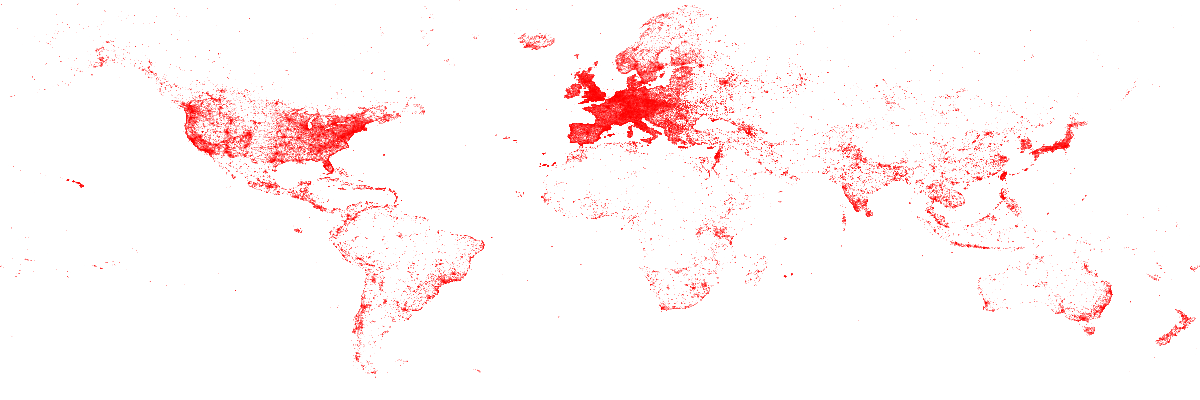

In [63]:
# Test with a small random subset first
test_df = pandas_df#.sample(1_000_000, random_state=42, replace=True)

# Get the specific range of just these points
test_x_range = (test_df['x'].min(), test_df['x'].max())
test_y_range = (-8723970.81755283, 11723970.81755283)

# Try rendering the test subset
canvas = ds.Canvas(plot_width=1200, plot_height=400, x_range=test_x_range, y_range=test_y_range)
agg = canvas.points(test_df, 'x', 'y', ds.count())
img = tf.shade(agg, cmap=['white', 'red'])
display(img.to_pil())

In [64]:
xrange = test_x_range
yrange = test_y_range

In [65]:
# One dot per datapoint
canvas = ds.Canvas(plot_width=1200, plot_height=900, x_range=x_range, y_range=y_range)
agg = canvas.points(pandas_df, 'x', 'y', agg=ds.count_cat('cluster'))
img = tf.shade(agg, cmap=cc.warm, how='eq_hist', min_alpha=50)
img = tf.set_background(img, color='black')
display(img.to_pil())

AttributeError: module 'colorcet' has no attribute 'warm'

In [ ]:
canvas = ds.Canvas(plot_width=1200, plot_height=900, x_range=x_range, y_range=y_range)

agg_density = canvas.points(pandas_df, 'x', 'y', ds.count())
img_density = tf.shade(agg_density, cmap=['white', 'red'], how='log')
display(img_density.to_pil())